**New York University** \\
**ECE GY- 7123 Deep Learning - Mini Project** \\
Slimming Down ResNet: Optimizing Deep Learning for Resource-Constrained
Environments \\
By Vamsi Krishna Bunga - vb2279, Sakshi Kulkarni - smk8939, Amrutha Patil - ap7982

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor
from torch.optim.lr_scheduler import OneCycleLR
from torchsummary import summary
from torchvision.utils import make_grid
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
# Define transforms for training data and testing data
transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                transforms.RandomHorizontalFlip(),
																                transforms.ToTensor(),
																								        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
transform_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

In [3]:
# Import train and test datasets 
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

100%|██████████| 170498071/170498071 [00:02<00:00, 61227951.81it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Define classes for train dataset
classes = trainset.class_to_idx

In [5]:
# Define the batch size
batch = 32

In [6]:
# Define data loaders for train and test data
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch, shuffle=False, num_workers=4)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


<ipython-input-7-9395ea726562>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stdDev = torch.tensor(means).reshape(1,3,1,1)


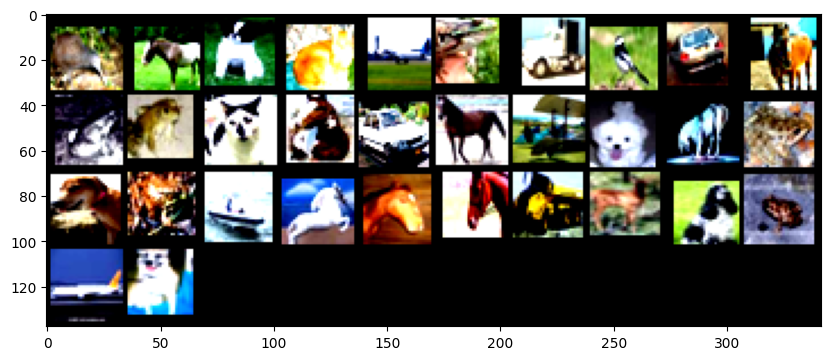

In [7]:
# Preview the data for reference

# Define data dimension 
data_stats = [(0.5,0.5,0.5),(0.5,0.5,0.5)]

# Function to denormalize data
def denormalize(images,means,stdDev):
  means = torch.tensor(means).reshape(1,3,1,1)
  stdDev = torch.tensor(means).reshape(1,3,1,1)
  return(images*stdDev+means)

# Function to show data
def showPreview(dataimglab):
  for images,labels in dataimglab:
    fig,ax = plt.subplots(figsize=(10,10))
    ax.imshow(make_grid(denormalize(images,*data_stats),10).permute(1,2,0))
    break

# Preview data
showPreview(train_loader)  

In [8]:
# Defining basic neural network block
class BasicBlock(nn.Module):
  def __init__(self, in_planes, planes, stride=1, dropout =0.1):
    super(BasicBlock, self).__init__() 
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)    
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.dropout = nn.Dropout(p = dropout)
    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != planes:
      self.shortcut = nn.Sequential(nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False), nn.BatchNorm2d(planes))

  def forward(self, x):
    out = self.dropout(F.relu(self.bn1(self.conv1(x))))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

In [9]:
# Defining Resnet architecture with the most effecient parameters 
class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10, dropout =0.1):
    super(ResNet, self).__init__()
    self.in_planes = 32
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3,stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(32)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.linear2 = nn.Linear(256, 128)
    self.linear = nn.Linear(128, num_classes)
    self.dropout = nn.Dropout(p = dropout)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
        layers.append(block(self.in_planes, planes, stride))
        self.in_planes = planes
    return nn.Sequential(*layers)

  def forward(self, x):
    out = self.dropout(F.relu(self.bn1(self.conv1(x)))) 
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = F.avg_pool2d(out, 6)
    out = out.view(out.size(0), -1)
    out = self.linear2(out)
    out = self.linear(out)
    return out

In [10]:
# Defining the loss and accuracy variables
train_acc = []
test_acc_l1 = []
train_losses = []
test_losses_l1 = []
epoch_train_losses = []

In [11]:
# Function to train the model
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar=tqdm(train_loader)
  correct = 0
  processed = 0
  epoch_loss = 0
  criterion= nn.CrossEntropyLoss().to(device)

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss  = criterion(y_pred, target)
    epoch_loss += loss
    train_losses.append(loss)
    loss.backward()
    optimizer.step()

    # get the index of the max log-probability
    pred = y_pred.argmax(dim=1, keepdim=True)  
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  
  train_acc.append(100*correct/processed)
  return epoch_loss/len(train_loader.dataset), train_acc

In [12]:
# Function to test the model
def test(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  criterion= nn.CrossEntropyLoss().to(device)
    
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += criterion(output, target).item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_losses_l1.append(test_loss)
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(test_loss, correct, len(test_loader.dataset),
                                                                               100. * correct / len(test_loader.dataset)))
  test_acc_l1.append(100. * correct / len(test_loader.dataset))

In [13]:
# Set cuda as device for faster processing
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [14]:
# Create the Restnet model 
model = ResNet(BasicBlock, [2,2,2,2]).to(device)
model

ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (shortcut): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(

In [15]:
# Check the number of parameters
param_check = sum(p.numel() for p in model.parameters() if p.requires_grad)
param_check

2792106

In [16]:
# Check the number of parameters using torchsummary.summary function
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
           Dropout-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,432
       BatchNorm2d-5           [-1, 64, 32, 32]             128
           Dropout-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Conv2d-9           [-1, 64, 32, 32]           2,048
      BatchNorm2d-10           [-1, 64, 32, 32]             128
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
          Dropout-14           [-1, 64,

The number of trainable parameters used by our model is 2,792,106.
We were successfully able to reduce the numbr of parameters by modifying the traditional ResNet architecture.

In [17]:
# Initialize the number of epochs, learning Rate and momentum
epochs = 30
LR = 0.0001
moment = 0.8

In [18]:
# Train the model
arr_train1 =[]
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=moment)
scheduler = OneCycleLR(optimizer,max_lr=0.1,total_steps=epochs)

for epoch in range(epochs):
  print(f'Epoch: {epoch} Learning_Rate {scheduler.get_lr()}')
  train_epoch_loss, train_epoch_accuracy = train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)
  epoch_train_losses.append(train_epoch_loss)
  scheduler.step()

/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:1699: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 0 Learning_Rate [0.0040000000000000036]


Loss=0.6884328126907349 Batch_id=1562 Accuracy=46.35: 100%|██████████| 1563/1563 [00:51<00:00, 30.48it/s]



Test set: Average loss: 0.0326, Accuracy: 6302/10000 (63.0200%)

Epoch: 1 Learning_Rate [0.0076537824394582454]


Loss=1.2565417289733887 Batch_id=1562 Accuracy=64.88: 100%|██████████| 1563/1563 [00:50<00:00, 30.67it/s]



Test set: Average loss: 0.0227, Accuracy: 7507/10000 (75.0700%)

Epoch: 2 Learning_Rate [0.018058874503045733]


Loss=1.0045816898345947 Batch_id=1562 Accuracy=71.40: 100%|██████████| 1563/1563 [00:48<00:00, 32.03it/s]



Test set: Average loss: 0.0239, Accuracy: 7542/10000 (75.4200%)

Epoch: 3 Learning_Rate [0.03363119524647569]


Loss=0.4931046962738037 Batch_id=1562 Accuracy=75.91: 100%|██████████| 1563/1563 [00:48<00:00, 32.10it/s]



Test set: Average loss: 0.0217, Accuracy: 7711/10000 (77.1100%)

Epoch: 4 Learning_Rate [0.052000000000000005]


Loss=0.7758798599243164 Batch_id=1562 Accuracy=79.37: 100%|██████████| 1563/1563 [00:49<00:00, 31.40it/s]



Test set: Average loss: 0.0187, Accuracy: 8121/10000 (81.2100%)

Epoch: 5 Learning_Rate [0.0703688047535243]


Loss=0.49078109860420227 Batch_id=1562 Accuracy=81.76: 100%|██████████| 1563/1563 [00:50<00:00, 31.14it/s]



Test set: Average loss: 0.0191, Accuracy: 8153/10000 (81.5300%)

Epoch: 6 Learning_Rate [0.08594112549695429]


Loss=0.25308242440223694 Batch_id=1562 Accuracy=83.41: 100%|██████████| 1563/1563 [00:50<00:00, 30.90it/s]



Test set: Average loss: 0.0140, Accuracy: 8549/10000 (85.4900%)

Epoch: 7 Learning_Rate [0.09634621756054176]


Loss=0.4650734066963196 Batch_id=1562 Accuracy=84.81: 100%|██████████| 1563/1563 [00:51<00:00, 30.60it/s]



Test set: Average loss: 0.0159, Accuracy: 8410/10000 (84.1000%)

Epoch: 8 Learning_Rate [0.1]


Loss=0.40928569436073303 Batch_id=1562 Accuracy=86.29: 100%|██████████| 1563/1563 [00:51<00:00, 30.50it/s]



Test set: Average loss: 0.0135, Accuracy: 8612/10000 (86.1200%)

Epoch: 9 Learning_Rate [0.09944154354509119]


Loss=0.2840156555175781 Batch_id=1562 Accuracy=87.88: 100%|██████████| 1563/1563 [00:51<00:00, 30.45it/s]



Test set: Average loss: 0.0125, Accuracy: 8765/10000 (87.6500%)

Epoch: 10 Learning_Rate [0.0977786491747459]


Loss=0.14573560655117035 Batch_id=1562 Accuracy=88.68: 100%|██████████| 1563/1563 [00:50<00:00, 30.66it/s]



Test set: Average loss: 0.0145, Accuracy: 8621/10000 (86.2100%)

Epoch: 11 Learning_Rate [0.09504846320134738]


Loss=0.16009224951267242 Batch_id=1562 Accuracy=89.43: 100%|██████████| 1563/1563 [00:50<00:00, 31.00it/s]



Test set: Average loss: 0.0119, Accuracy: 8808/10000 (88.0800%)

Epoch: 12 Learning_Rate [0.09131197346804489]


Loss=0.1791202574968338 Batch_id=1562 Accuracy=90.20: 100%|██████████| 1563/1563 [00:50<00:00, 31.18it/s]



Test set: Average loss: 0.0116, Accuracy: 8936/10000 (89.3600%)

Epoch: 13 Learning_Rate [0.08665264698111695]


Loss=0.09511249512434006 Batch_id=1562 Accuracy=90.95: 100%|██████████| 1563/1563 [00:50<00:00, 30.99it/s]



Test set: Average loss: 0.0120, Accuracy: 8868/10000 (88.6800%)

Epoch: 14 Learning_Rate [0.0811745653949763]


Loss=0.370469868183136 Batch_id=1562 Accuracy=91.66: 100%|██████████| 1563/1563 [00:50<00:00, 30.99it/s]



Test set: Average loss: 0.0115, Accuracy: 8923/10000 (89.2300%)

Epoch: 15 Learning_Rate [0.0750001]


Loss=0.1120423972606659 Batch_id=1562 Accuracy=92.45: 100%|██████████| 1563/1563 [00:50<00:00, 30.94it/s]



Test set: Average loss: 0.0101, Accuracy: 9004/10000 (90.0400%)

Epoch: 16 Learning_Rate [0.06826717815011489]


Loss=0.4096471965312958 Batch_id=1562 Accuracy=92.88: 100%|██████████| 1563/1563 [00:50<00:00, 31.01it/s]



Test set: Average loss: 0.0118, Accuracy: 8896/10000 (88.9600%)

Epoch: 17 Learning_Rate [0.06112620219362893]


Loss=0.39141225814819336 Batch_id=1562 Accuracy=93.40: 100%|██████████| 1563/1563 [00:49<00:00, 31.28it/s]



Test set: Average loss: 0.0116, Accuracy: 8998/10000 (89.9800%)

Epoch: 18 Learning_Rate [0.0537366897333025]


Loss=0.18084408342838287 Batch_id=1562 Accuracy=93.94: 100%|██████████| 1563/1563 [00:49<00:00, 31.29it/s]



Test set: Average loss: 0.0109, Accuracy: 9025/10000 (90.2500%)

Epoch: 19 Learning_Rate [0.046263710266697504]


Loss=0.01126211229711771 Batch_id=1562 Accuracy=94.55: 100%|██████████| 1563/1563 [00:49<00:00, 31.41it/s]



Test set: Average loss: 0.0109, Accuracy: 8985/10000 (89.8500%)

Epoch: 20 Learning_Rate [0.03887419780637107]


Loss=0.02060498297214508 Batch_id=1562 Accuracy=95.24: 100%|██████████| 1563/1563 [00:49<00:00, 31.46it/s]



Test set: Average loss: 0.0105, Accuracy: 9117/10000 (91.1700%)

Epoch: 21 Learning_Rate [0.03173322184988512]


Loss=0.293936550617218 Batch_id=1562 Accuracy=95.71: 100%|██████████| 1563/1563 [00:49<00:00, 31.36it/s]



Test set: Average loss: 0.0105, Accuracy: 9118/10000 (91.1800%)

Epoch: 22 Learning_Rate [0.025000300000000013]


Loss=0.19608347117900848 Batch_id=1562 Accuracy=96.27: 100%|██████████| 1563/1563 [00:50<00:00, 30.93it/s]



Test set: Average loss: 0.0097, Accuracy: 9213/10000 (92.1300%)

Epoch: 23 Learning_Rate [0.0188258346050237]


Loss=0.21463435888290405 Batch_id=1562 Accuracy=96.81: 100%|██████████| 1563/1563 [00:50<00:00, 30.81it/s]



Test set: Average loss: 0.0105, Accuracy: 9189/10000 (91.8900%)

Epoch: 24 Learning_Rate [0.01334775301888306]


Loss=0.008095337077975273 Batch_id=1562 Accuracy=97.45: 100%|██████████| 1563/1563 [00:50<00:00, 30.87it/s]



Test set: Average loss: 0.0109, Accuracy: 9241/10000 (92.4100%)

Epoch: 25 Learning_Rate [0.008688426531955128]


Loss=0.24222099781036377 Batch_id=1562 Accuracy=97.99: 100%|██████████| 1563/1563 [00:50<00:00, 30.81it/s]



Test set: Average loss: 0.0106, Accuracy: 9249/10000 (92.4900%)

Epoch: 26 Learning_Rate [0.004951936798652629]


Loss=0.015699541196227074 Batch_id=1562 Accuracy=98.34: 100%|██████████| 1563/1563 [00:51<00:00, 30.59it/s]



Test set: Average loss: 0.0105, Accuracy: 9265/10000 (92.6500%)

Epoch: 27 Learning_Rate [0.002221750825254118]


Loss=0.00206843507476151 Batch_id=1562 Accuracy=98.66: 100%|██████████| 1563/1563 [00:49<00:00, 31.42it/s]



Test set: Average loss: 0.0108, Accuracy: 9282/10000 (92.8200%)

Epoch: 28 Learning_Rate [0.0005588564549088189]


Loss=0.12477052956819534 Batch_id=1562 Accuracy=98.70: 100%|██████████| 1563/1563 [00:50<00:00, 30.92it/s]



Test set: Average loss: 0.0108, Accuracy: 9277/10000 (92.7700%)

Epoch: 29 Learning_Rate [4e-07]


Loss=0.021413827314972878 Batch_id=1562 Accuracy=98.74: 100%|██████████| 1563/1563 [00:50<00:00, 30.75it/s]



Test set: Average loss: 0.0107, Accuracy: 9286/10000 (92.8600%)



The final test accuracy of our model after 30 epochs is 93.4%. 

In [19]:
# Convert accuracy and loss variables from cuda tensors to .cpu()
arr_train_acc=np.array(torch.Tensor(train_acc).cpu())
arr_test_acc=np.array(torch.Tensor(test_acc_l1).cpu())
train_loss_per_epoch=np.array(torch.Tensor(epoch_train_losses).cpu())
arr_train=np.array(torch.Tensor(train_losses).cpu())
arr_test=np.array(torch.Tensor(test_losses_l1).cpu())

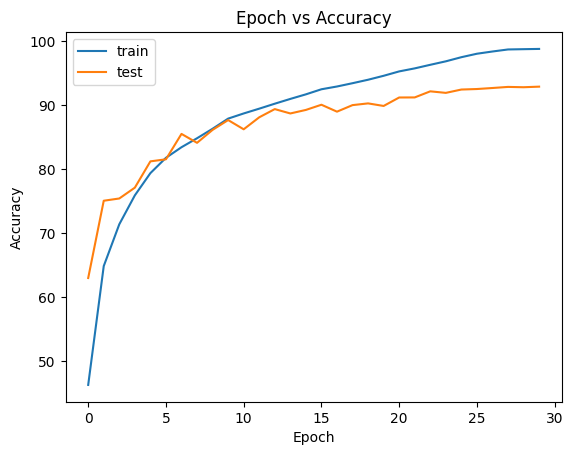

In [20]:
# Plot the accuracy
plt.plot(arr_train_acc)
plt.plot(arr_test_acc)
plt.legend(["train","test"])
plt.title("Epoch vs Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

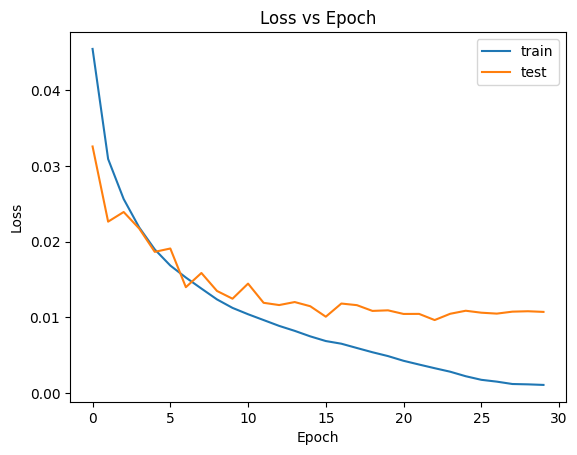

In [21]:
# Plot the loss
plt.plot(train_loss_per_epoch)
plt.plot(arr_test)
plt.legend(["train","test"])
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [22]:
# Save the model
model.cpu()
model_scripted = torch.jit.script(model)
model_scripted.save('ResNet_lite.pt')
print("Saved Model")

Saved Model


In [23]:
# Function to get prediction labels and probablities
def get_predictions(model, iterator, device):
  model.eval()
  labels = []
  probs = []

  with torch.no_grad():
    for (img,lbl) in iterator:
      img = img.to(device)
      outputs = model(img)    
      y_prob = F.softmax(outputs, dim = -1)
      top_pred = y_prob.argmax(1, keepdim = True)
      labels.append(lbl.cpu())
      probs.append(y_prob.cpu())

  labels = torch.cat(labels, dim = 0)
  probs = torch.cat(probs, dim = 0)
  return labels, probs

# Get our model predictions
model.to('cuda')
labels, probs = get_predictions(model, test_loader, device)
pred_labels = torch.argmax(probs, 1)

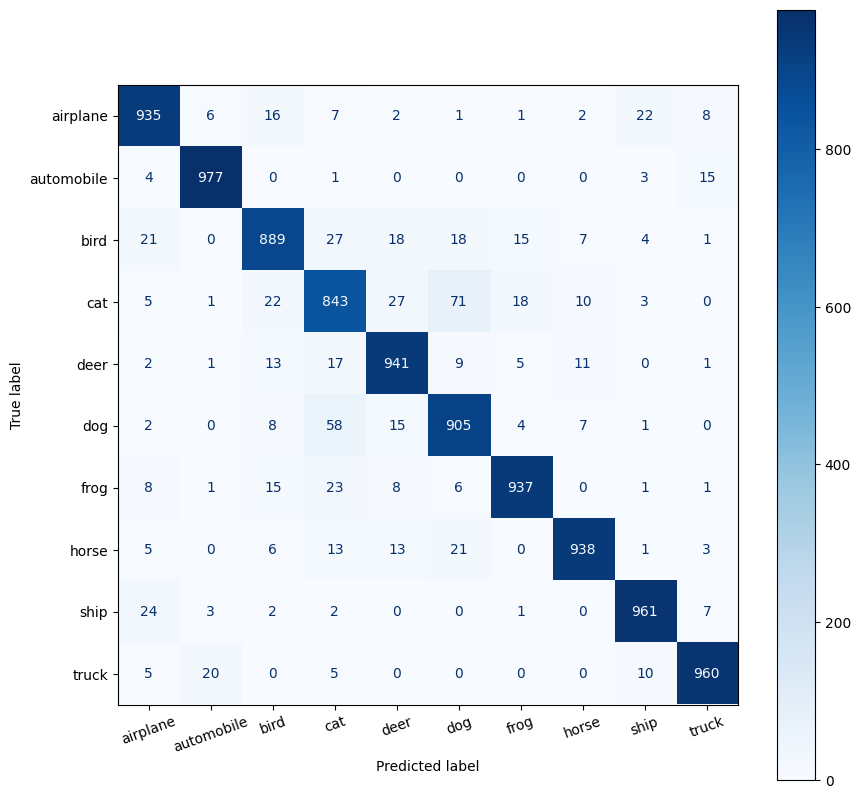

In [24]:
# Function to plot the confusion matrix
def plot_confusion_matrix(labels, pred_labels, classes):
  fig = plt.figure(figsize = (10, 10));
  ax = fig.add_subplot(1, 1, 1);
  cm = confusion_matrix(labels, pred_labels);
  cm = ConfusionMatrixDisplay(cm, display_labels = classes);
  cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
  plt.xticks(rotation = 20)

# Plot the confusion matrix for our model
plot_confusion_matrix(labels, pred_labels, classes)